In [4]:
from preprocessing import *
import pandas as pd
import os
from fst4conll import *
from conll import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%%bash
dpath='NL2SparQL4NLU/dataset/NL2SparQL4NLU'
spath='dataset'
mkdir -p $spath

cp $dpath.train.utterances.txt $spath/trn.txt
cp $dpath.test.utterances.txt $spath/tst.txt

cp $dpath.train.conll.txt $spath/trn.conll
cp $dpath.test.conll.txt $spath/tst.conll

## Improvement 1: Remove O-tag

In [6]:
#generate files
if not os.path.exists('improvement1'):
    os.makedirs('improvement1')
tf_min=1
#INPUT
trn_data = read_corpus('dataset/trn.txt')
trn_lex, out = cutoff(trn_data, tf_min)

with open('improvement1/isyms.trn.txt', 'w') as f:
    f.write("\n".join(trn_lex) + "\n")

#OUTPUT
trn = read_corpus_conll('dataset/trn.conll')
tags = get_column(trn, column=-1)
        
tlex, out_t = cutoff(tags, tf_min)
with open('improvement1/osyms.t.lst.txt', 'w') as f:
    f.write("\n".join(tlex) + "\n")

In [7]:
#create trn.wt.txt
with open('dataset/trn.conll') as f:
    content = f.read().strip('\n').split('\n\n')
with open('improvement1/trn.wt.txt', 'w') as f:
    for sentence in content:
        list_wt = [(x.split('\t')[0], x.split('\t')[1]) for x in sentence.split('\n')]
        list_t = []
        for i in range(len(list_wt)):
            tag = list_wt[i][1]
            if tag == 'O':
                tag = list_wt[i][0]
            list_t.append(tag)
        f.write(' '.join(list_t) +  '\n')

In [8]:
%%bash
#make input/output lexicons
bpath='improvement1'
ngramsymbols $bpath/isyms.trn.txt   $bpath/isyms.txt
ngramsymbols $bpath/osyms.t.lst.txt $bpath/osyms.t.txt

rm $bpath/isyms.trn.txt
rm $bpath/osyms.t.lst.txt

## Create lexicon

In [9]:
%%bash 
#use lexicons with both cutoff
bpath='improvement1'
cat $bpath/isyms.txt $bpath/osyms.t.txt | cut -f 1 | sort | uniq > $bpath/lex.lst.txt
ngramsymbols $bpath/lex.lst.txt $bpath/lex.txt
rm $bpath/lex.lst.txt

## Extract test sentences

In [7]:
%%bash
farcompilestrings \
    --symbols=improvement1/lex.txt \
    --keep_symbols \
    --unknown_symbol='<unk>' \
    dataset/tst.txt tst.far

wdir='improvement1/wdir'
mkdir -p 'improvement1/wdir'
farextract --filename_prefix="$wdir/" tst.far

## Create W2T MLE without O

In [8]:
from collections import defaultdict
import math

# ---------------- if no cutoff ---------------------
if tf_min < 2:
    training_data = []
    with open('dataset/trn.conll') as f:
        content = f.read().strip('\n').split('\n\n')
        
    for sentence in content:
        list_wt = [(x.split('\t')[0], x.split('\t')[1]) for x in sentence.split('\n')]
        training_data += list_wt
    
    #replace O-tag with w
    for i in range(len(training_data)):
        if training_data[i][1] == 'O':
            training_data[i] = (training_data[i][0], training_data[i][0])
    
    with open('improvement1/w2t_mle.txt', 'w') as f:
        t_count = defaultdict(int)
        wt_count = defaultdict(int)
        p_wt = defaultdict(float)
        # count c(w,t) and c(t)
        for t in training_data:
            t_count[t[1]] += 1
            wt = "{} {}".format(t[0], t[1])
            wt_count[wt] += 1
               
        # compute prob p(w|t) with add-alpha smoothing    
        V = len(t_count)
        alpha = 0
        for wt in wt_count:
            _,tag = wt.split()
            p_wt[wt] =  - math.log( (wt_count[wt]+alpha) / (t_count[tag]+(alpha*V)))
        for tag in t_count:
            #if tag.startswith("B-") or tag.startswith("I-"):
            p_wt["<unk> {}".format(tag)] = - math.log(1 / V)
        
        for wt in p_wt:
            w,t = wt.split()
            f.write("0 0 {} {} {}\n".format(w, t, p_wt[wt]))
        f.write('0')
        
# ---------------------- if cutoff --------------------------
if tf_min > 1:
    training_data = []
    with open('dataset/trn.conll') as f:
        content = f.read().strip('\n').split('\n\n')

    for sentence in content:
        list_wt = [(x.split('\t')[0], x.split('\t')[1]) for x in sentence.split('\n')]
        training_data += list_wt
    
    #replace O-tag with w
    for i in range(len(training_data)):
        if training_data[i][1] == 'O':
            training_data[i] = (training_data[i][0], training_data[i][0])
    training_data = sorted(training_data,key = lambda x: x[1])
    
    #replace OOV words and tags with <unk>
    for i in range(len(training_data)):
        if training_data[i][0] in out:
            if training_data[i][1] in out:
                training_data[i] = ('<unk>', '<unk>')
            else:
                training_data[i] = ('<unk>', training_data[i][1])        
        if training_data[i][1] in out_t:
            training_data[i] = (training_data[i][0],'<unk>')
    training_data = sorted(training_data,key = lambda x: x[1])
    
    with open('improvement1/w2t_mle.txt', 'w') as f:
        t_count = defaultdict(int)
        wt_count = defaultdict(int)
        p_wt = defaultdict(float)
        # count c(w,t) and c(t)
        for t in training_data:
            t_count[t[1]] += 1
            wt = "{} {}".format(t[0], t[1])
            wt_count[wt] += 1
            
        # compute prob p(w|t) with add-alpha smoothing    
        V = len(t_count)
        alpha = 1
        for wt in wt_count:
            word,tag = wt.split()
            if word == '<unk>':
                p_wt[wt] = - math.log(1 / V)
            else:
                p_wt[wt] =  - math.log( (wt_count[wt]+alpha) / (t_count[tag]+(alpha*V)) )
                       
        for wt in p_wt:
            w,t = wt.split()
            f.write("0 0 {} {} {}\n".format(w, t, p_wt[wt]))
        f.write('0')

In [3]:
%%bash
bpath='improvement1'
fstcompile \
    --isymbols=$bpath/lex.txt \
    --osymbols=$bpath/lex.txt \
    --keep_isymbols \
    --keep_osymbols \
    $bpath/w2t_mle.txt | fstarcsort - > $bpath/w2t_mle.bin
    
fstinfo $bpath/w2t_mle.bin | head -n 8  

fst type                                          vector
arc type                                          standard
input symbol table                                improvement1/lex.txt
output symbol table                               improvement1/lex.txt
# of states                                       1
# of arcs                                         3040
initial state                                     0
# of final states                                 1


## Create LM

In [11]:
%%bash
#CREATE LANGUAGE MODELS
mkdir -p 'improvement1/models'
lmpath='improvement1/models'
bpath='improvement1'
for ngram in 1 2 3 4 5
do
    for smooth in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        farcompilestrings --symbols=improvement1/lex.txt --keep_symbols \
                          --unknown_symbol='<unk>' $bpath/trn.wt.txt $bpath/trn.far
        ngramcount --order=$ngram $bpath/trn.far $bpath/trn.cnt
        ngrammake --method=$smooth $bpath/trn.cnt $lmpath/$smooth.$ngram.lm
        rm $bpath/trn.cnt
        rm $bpath/trn.far
    done
done

## Create W2T back to O

In [11]:
def w2t_back(out):
    special = {'<epsilon>', 'O', '<unk>'}
    state = '0'    # wfst specification state
    fs = " "       # wfst specification column separator
    otag = 'O'
    
    lines = [line.strip().split("\t") for line in open('improvement1/lex.txt', 'r')]
    #lines2 = [line.strip().split("\t") for line in open('variation1/osyms.t.txt', 'r')]

    with open(out, 'w') as f:
        for line in lines:
            word = line[0]
            if word.startswith("B-") or word.startswith("I-"):   
                f.write(fs.join([state, state] + [word] + [word]) + "\n")
            else:
                f.write(fs.join([state, state] + [word] + [otag]) + "\n")
        f.write(state + "\n")

In [12]:
w2t_back('improvement1/w2t_bO.txt')

In [1]:
%%bash
bpath='improvement1'
fstcompile \
    --isymbols=$bpath/lex.txt \
    --osymbols=$bpath/lex.txt \
    --keep_isymbols \
    --keep_osymbols \
    $bpath/w2t_bO.txt $bpath/w2t_bO.bin
    
fstinfo $bpath/w2t_bO.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                improvement1/lex.txt
output symbol table                               improvement1/lex.txt
# of states                                       1
# of arcs                                         1772
initial state                                     0
# of final states                                 1


In [14]:
%%bash
##TEST
wdir='improvement1/wdir'
mkdir -p 'improvement1/wdir'

cp $wdir/tst.txt-0005 sent.fsa

fstcompose sent.fsa improvement1/w2t_mle.bin |\
fstcompose - improvement1/models/absolute.2.lm |\
fstcompose - improvement1/w2t_bO.bin |\
fstshortestpath | fstrmepsilon | fsttopsort |\
fstprint --isymbols=improvement1/lex.txt


0	1	who	O	2.56040716
1	2	is	O	2.08567691
2	3	in	O	3.03797865
3	4	<unk>	B-movie.language	8.24094009
4	0.560626388


In [15]:
%%bash

wdir='improvement1/wdir'
farr=($(ls $wdir))
mkdir -p 'improvement1/result'
mkdir -p 'improvement1/scores'
rpath='improvement1/result'

for ngo in 1 2 3 4 5
do
    for lm in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        for f in ${farr[@]}
        do
            fstcompose $wdir/$f improvement1/w2t_mle.bin |\
            fstcompose - improvement1/models/$lm.$ngo.lm |\
            fstcompose - improvement1/w2t_bO.bin |\
            fstshortestpath | fstrmepsilon | fsttopsort |\
            fstprint --isymbols=improvement1/lex.txt
        done > $rpath/pred.$lm.$ngo.txt
    done
done


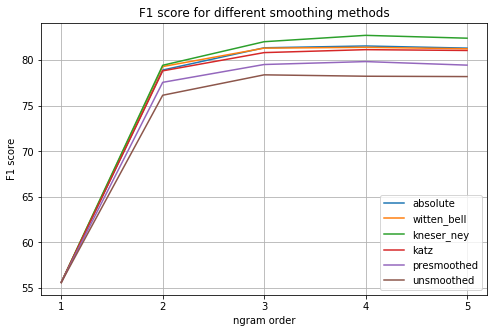

cutoff:  1
           0          1          2          3          4
0  55.595668  78.930675  81.374322  81.571816  81.337551
1  55.595668  79.311906  81.334536  81.424707  81.264108
2  55.595668  79.452055  82.041933  82.739726  82.428115
3  55.595668  78.840054  80.845324  81.168539  81.078652
4  55.595668  77.578475  79.537367  79.858030  79.467849
5  55.595668  76.160991  78.402107  78.249337  78.210806


In [16]:
ngrams = [1,2,3,4,5]
smoothing_methods = ["absolute", "witten_bell", "kneser_ney", "katz", "presmoothed", "unsmoothed"]
f1scores = []

with open("improvement1/scores/cf{}.alpha{}.txt".format(tf_min,alpha), 'w') as f:
    f.write("Cutoff: {}\tAlpha: {}\n".format(tf_min,alpha))               
    for sm in smoothing_methods:
        sms = []    
        f.write("Smoothing method: {}\n".format(sm))
        for ngo in ngrams:

            refs = read_corpus_conll('dataset/tst.conll')
            hyps = read_fst4conll('improvement1/result/pred.'+sm+'.'+str(ngo)+'.txt')

            results = evaluate(refs, hyps)

            pd_tbl = pd.DataFrame().from_dict(results, orient='index').iloc[-1:]
            val = pd.DataFrame().from_dict(results, orient='index').iloc[-1,pd_tbl.columns.get_loc('f')]*100
            sms.append(val)
            f.write("{}: {}\t".format(ngo,round(val,3)))

        f1scores.append(sms)
        f.write("\n")

#------------------PLOT---------------------
plt.figure(figsize=(8,5))
for sm in range(len(smoothing_methods)):
    plt.plot(ngrams,f1scores[sm], label=smoothing_methods[sm])
plt.title("F1 score for different smoothing methods")
plt.xlabel("ngram order")
plt.ylabel("F1 score")
plt.legend(loc='best')
plt.xticks(ngrams)
plt.grid()
plt.show()



print("cutoff: ",tf_min)
print(pd.DataFrame(f1scores))